In [1]:
import pandas
import matplotlib.pyplot as plt

# Load and filter data

Concentration data https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory--laei--2016, see  concentrations excel files

In [4]:
no2 = pandas.read_csv('../data/CSV/LAEI2016_2016_NO2.csv')
pm25 = pandas.read_csv('../data/CSV/LAEI2016_2016_PM25.csv')

Educational establishment data, from https://get-information-schools.service.gov.uk/Downloads, see all establishment data

In [5]:
# edubase appears to use non ut8 encoding
edub = pandas.read_csv('../data/edubasealldata20190816.csv', encoding = "ISO-8859-1", low_memory = False)

32 London borough from this list https://en.wikipedia.org/wiki/List_of_London_boroughs, this can be used to filter edubase to extract estvblishments in London

In [6]:
bors = ['Barking and Dagenham', 'Barnet' ,'Bexley','Brent', 'Bromley','Camden','Croydon','Ealing','Enfield','Greenwich','Hackney', 'Hammersmith and Fulham','Haringey','Harrow','Havering','Hillingdon','Hounslow',
 'Islington', 'Kensington and Chelsea','Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest','Wandsworth','Westminster']

There are several ways of filtering edubase to show only nurseries, the EstablishmentTypeGroup (name) field has a "local authority nursery school" option, but there are only 95 of these in London, PhaseOfEducation (name) has a "nursery" option these are the same as the local authority option.  A better filter are establishments which have nursery classes, where there are 2316, this doesn't include all of the nursery lablled establishment, so both filters are used

In [7]:
print(len(edub.loc[edub["LA (name)"].isin(bors)]), "establishments in the London boroughs")

5598 establishments in the London boroughs


In [8]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["PhaseOfEducation (name)"] == "Nursery"))]), "establishments in the London boroughs")

95 establishments in the London boroughs


In [9]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["TypeOfEstablishment (name)"] == "Local authority nursery school"))]), "establishments in the London boroughs")

95 establishments in the London boroughs


In [10]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes"))]), "establishments in the London boroughs")

2316 establishments in the London boroughs


In [11]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes")  & (edub["TypeOfEstablishment (name)"] == "Local authority nursery school"))]), "establishments in the London boroughs")

81 establishments in the London boroughs


In [12]:
print(len(edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes")  & (edub["PhaseOfEducation (name)"] == "Nursery"))]), "establishments in the London boroughs")

81 establishments in the London boroughs


In [13]:
nurseries = edub.loc[(edub["LA (name)"].isin(bors) & (edub["NurseryProvision (name)"] == "Has Nursery Classes"))]

In [14]:
nurseries =nurseries.append(edub.loc[(edub["LA (name)"].isin(bors) & (edub["TypeOfEstablishment (name)"] == "Local authority nursery school"))])

In [15]:
nurseries = nurseries.drop_duplicates('URN')

In [16]:
# exclude those with no spatial reference

In [17]:
nurseries = nurseries.loc[nurseries.Easting !=0]

In [20]:
nurseries.to_csv("../data/london_nurseries_edubase_2019.csv")

# Test data

Quick check to verfiy that the coordinate systems are the same, e.g. do the coordinates overlap, looks a little off

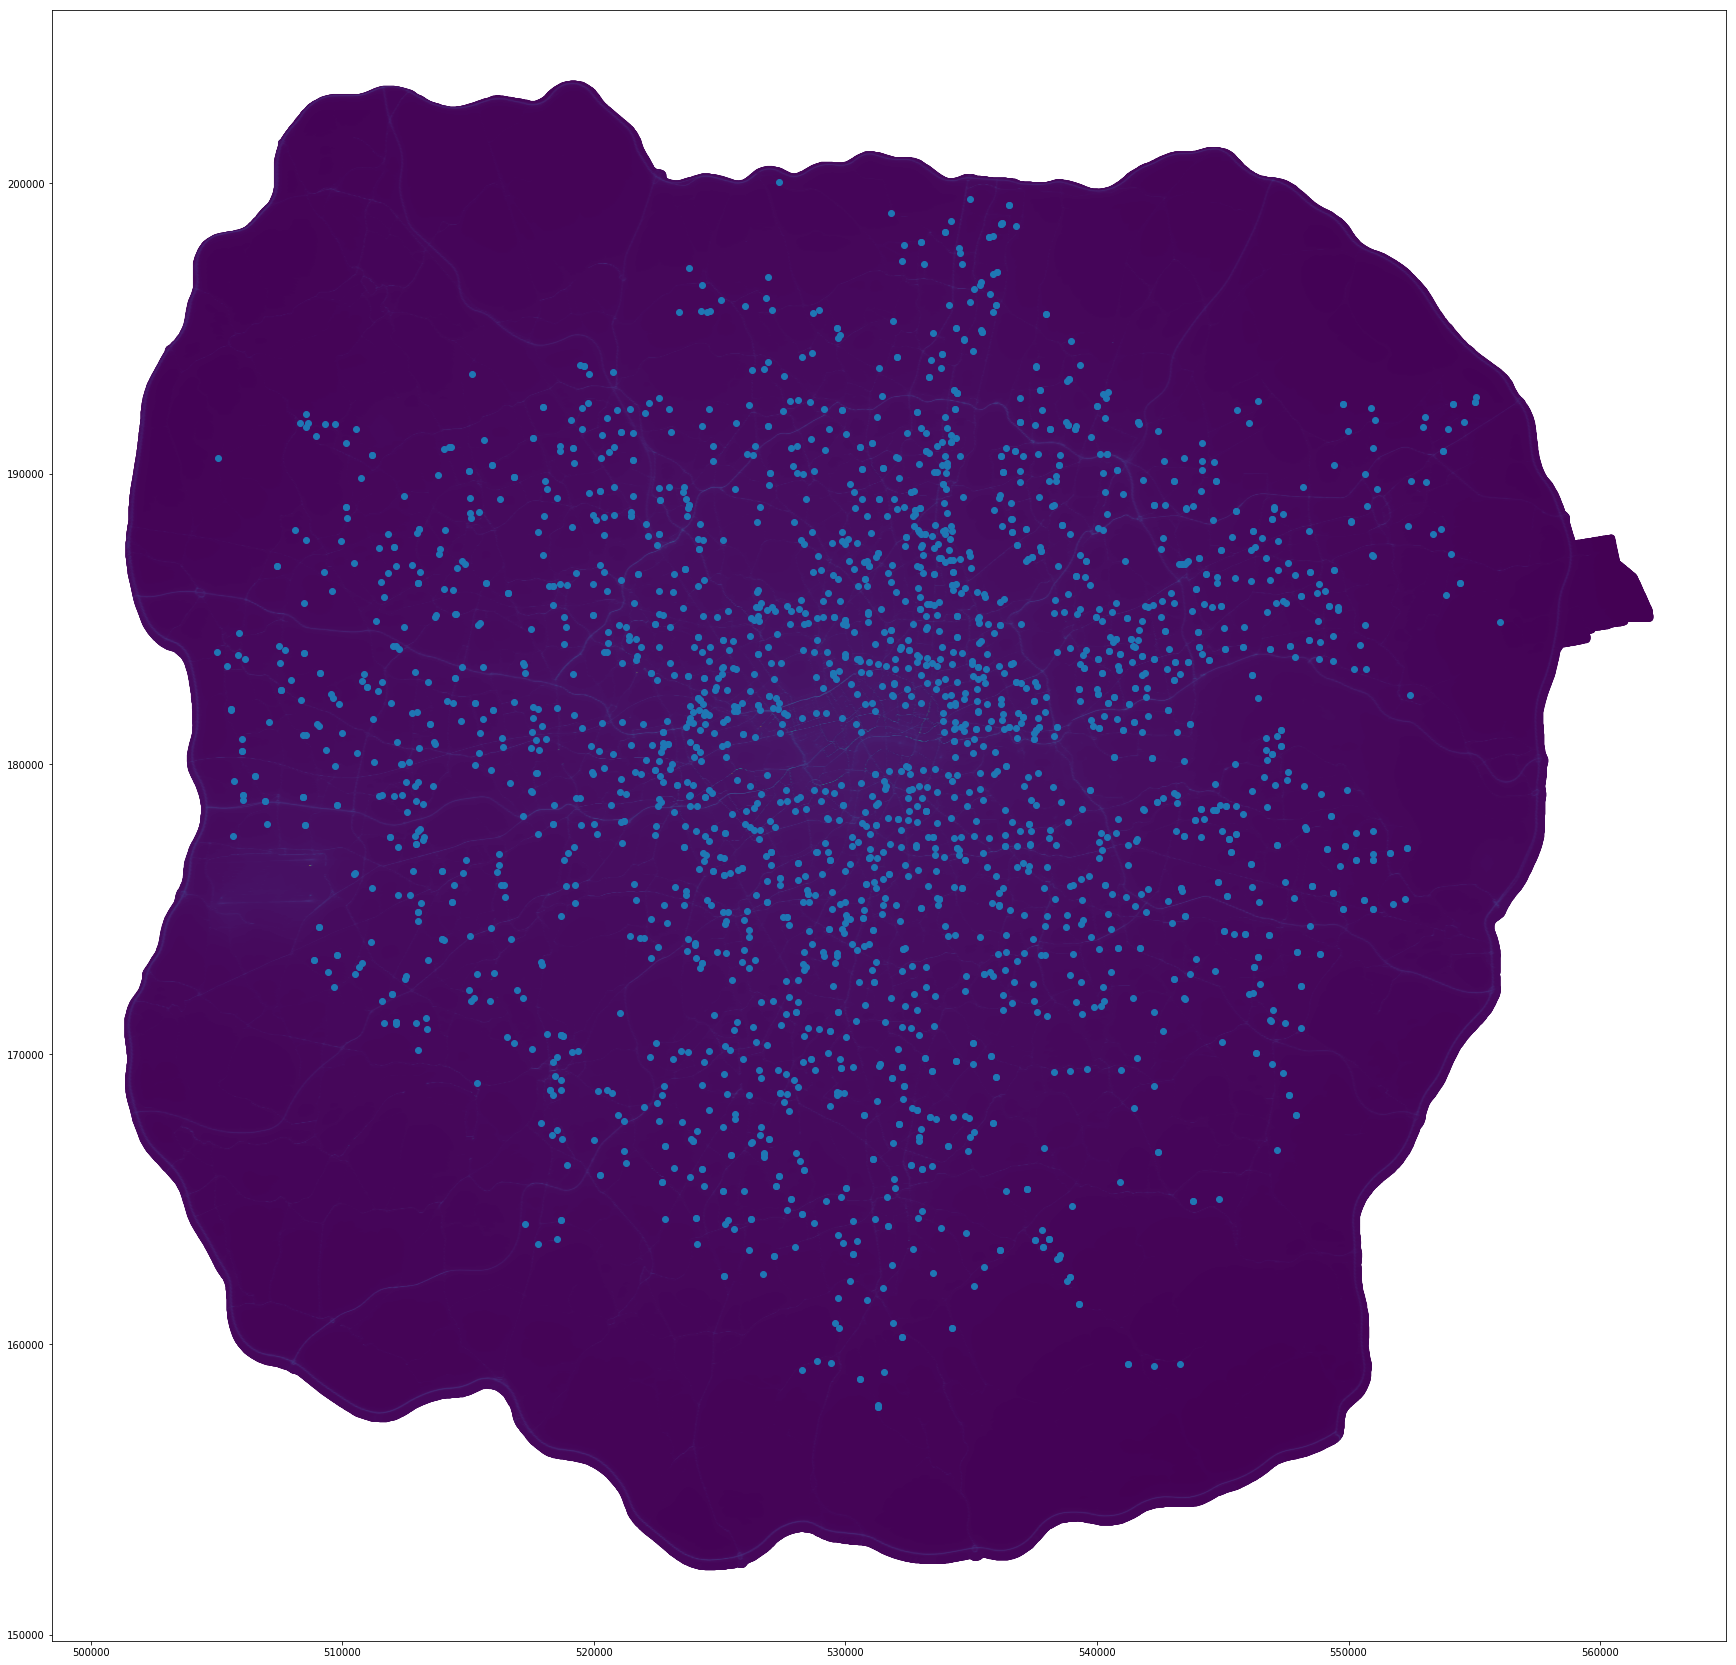

In [18]:
plt.figure(figsize=(30,30))
plt.scatter(no2.x.values, no2.y.values,c = no2.conc.values )
plt.scatter(nurseries.Easting.values, nurseries.Northing.values)